In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
train = pd.read_csv('../data/processed/train.csv')
train['Date'] = pd.to_datetime(train['Date'])

print(f"Training data loaded: {len(train)} rows")
print(f"Stocks: {train['Stock'].unique()}")
print(f"Features: {len(train.columns)} columns")

Training data loaded: 6380 rows
Stocks: ['BHARTIARTL' 'HDFCBANK' 'HINDUNILVR' 'ICICIBANK' 'INFY' 'ITC' 'KOTAKBANK'
 'RELIANCE' 'SBIN' 'TCS']
Features: 37 columns


# Visualizing new features

In [3]:
sample_stock = 'RELIANCE' #example just
stock_data = train[train['Stock'] == sample_stock].sort_values('Date')

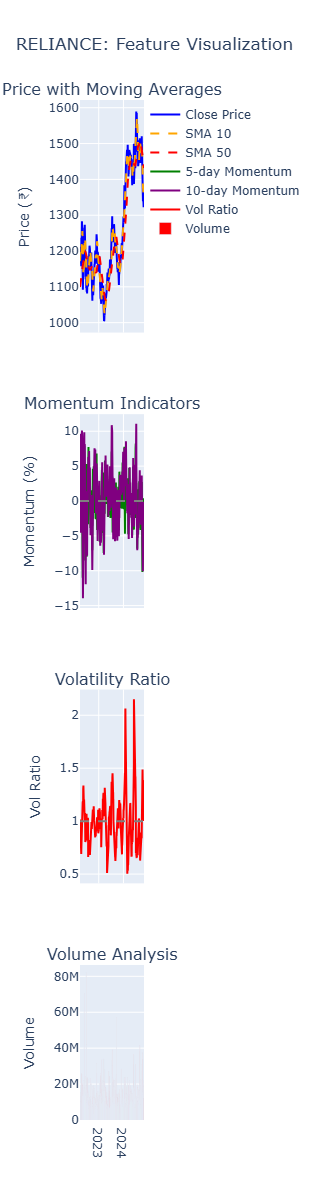

In [4]:
fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    subplot_titles=(
        'Price with Moving Averages',
        'Momentum Indicators',
        'Volatility Ratio',
        'Volume Analysis'
    ),
    vertical_spacing=0.08,
    row_heights=[0.3, 0.25, 0.25, 0.2]
)
#This here is for Moving Averages price
fig.add_trace(
    go.Scatter(x=stock_data['Date'], y=stock_data['Close'], name='Close Price', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=stock_data['Date'], y=stock_data['SMA_10'], name='SMA 10', line=dict(color='orange', dash='dash')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=stock_data['Date'], y=stock_data['SMA_50'], name='SMA 50', line=dict(color='red', dash='dash')),
    row=1, col=1
)

#This for Momentum Indicators

fig.add_trace(
    go.Scatter(x=stock_data['Date'], y=stock_data['Momentum_5']*100, name='5-day Momentum', line=dict(color='green')),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=stock_data['Date'], y=stock_data['Momentum_10']*100, name='10-day Momentum', line=dict(color='purple')),
    row=2, col=1
)
fig.add_hline(y=0, line_dash="dash", line_color="gray", row=2, col=1)

#This for volatility ratio

fig.add_trace(
    go.Scatter(x=stock_data['Date'], y=stock_data['Volatility_Ratio'], name='Vol Ratio', line=dict(color='red')),
    row=3, col=1
)
fig.add_hline(y=1.0, line_dash="dash", line_color="gray", row=3, col=1)

# This one's finally for volume
fig.add_trace(
    go.Bar(x=stock_data['Date'], y=stock_data['Volume'], name='Volume', marker_color='red'),
    row=4, col=1
)

fig.update_layout(
    height=1200,
    showlegend=True,
    title_text=f"{sample_stock}: Feature Visualization"
)

fig.update_yaxes(title_text="Price (₹)", row=1, col=1)
fig.update_yaxes(title_text="Momentum (%)", row=2, col=1)
fig.update_yaxes(title_text="Vol Ratio", row=3, col=1)
fig.update_yaxes(title_text="Volume", row=4, col=1)

fig.show()

# Feature correlation with a target

In [5]:
stock_data['Target'] = stock_data['Close'].shift(-1) / stock_data['Close'] - 1
#This is the target . Next day's return

In [6]:
feature_cols = [
    'RSI', 'MACD', 'Volatility', 
    'Momentum_5', 'Momentum_10',
    'Volatility_Ratio', 'Volume_MA_Ratio',
    'Price_Position', 'SMA_Distance',
    'Domestic_Index', 'IT_Index'
]

In [7]:
correlations = stock_data[feature_cols + ['Target']].corr()['Target'].drop('Target').sort_values(ascending=False)
print("\nFeature Correlation with Next-Day Returns:")
print(correlations)

fig = go.Figure(data=[
    go.Bar(
        x=correlations.values,
        y=correlations.index,
        orientation='h',
        marker_color=['green' if x > 0 else 'red' for x in correlations.values]
    )
])

fig.update_layout(
    title='Feature Importance: Correlation with Next-Day Returns',
    xaxis_title='Correlation',
    yaxis_title='Feature',
    height=500
)

fig.show()


Feature Correlation with Next-Day Returns:
Volatility_Ratio    0.030097
IT_Index            0.016250
Volatility          0.009967
Volume_MA_Ratio     0.001189
Price_Position     -0.021306
Momentum_5         -0.036703
MACD               -0.038076
SMA_Distance       -0.039769
Momentum_10        -0.040025
RSI                -0.040117
Domestic_Index     -0.053356
Name: Target, dtype: float64


# Sector Index

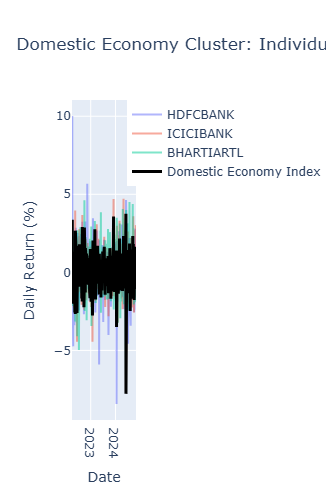

In [8]:
fig = go.Figure()

for stock in ['HDFCBANK', 'ICICIBANK', 'BHARTIARTL']:  # Domestic cluster
    stock_df = train[train['Stock'] == stock].sort_values('Date')
    fig.add_trace(go.Scatter(
        x=stock_df['Date'],
        y=stock_df['Daily_Return']*100,
        name=stock,
        mode='lines',
        opacity=0.5
    ))
    
domestic_avg = train.groupby('Date')['Domestic_Index'].first().reset_index()
fig.add_trace(go.Scatter(
    x=domestic_avg['Date'],
    y=domestic_avg['Domestic_Index']*100,
    name='Domestic Economy Index',
    mode='lines',
    line=dict(color='black', width=3)
))

fig.update_layout(
    title='Domestic Economy Cluster: Individual Stocks vs Sector Index',
    xaxis_title='Date',
    yaxis_title='Daily Return (%)',
    height=500
)

fig.show()

# Data splitting checkpoint

In [9]:
val = pd.read_csv('../data/processed/val.csv')
test = pd.read_csv('../data/processed/test.csv')

train_counts = train.groupby('Stock').size()
val_counts = val.groupby('Stock').size()
test_counts = test.groupby('Stock').size()

print(f"\nData split summary:")
print(f"Train:      {len(train):4d} samples")
print(f"Validation: {len(val):4d} samples")
print(f"Test:       {len(test):4d} samples")


Data split summary:
Train:      6380 samples
Validation: 1360 samples
Test:       1380 samples
